## 爬取网易126邮箱信封数据

**1 使用需知**
- 使用selenium爬取网易邮箱内容需要解决html网页中iframe的定向问题，每次点击之后浏览器对象都要重新定位
- xpath语法也不是固定的，像网易邮箱这种网站过段时间都会重新进行维护，xpath定位有时是需要进行更新的
- 所需第三方库：selenium（自动化操作）、lxml（提供xpath语法）、pandas（保存数据）
- selenium所需浏览器：Microsoft Edge（默认），但需要提前安装对应驱动，点击这里查看[安装教程](https://blog.csdn.net/tk1023/article/details/109078613)

**2 爬虫思路**
- 首先使用selenium来模拟点击登录网易126邮箱
- 然后进入到收件箱的页面中，统计当前页面下有多少条订单数据
- 对这些订单邮件进行遍历操作，模拟点击每一封订单邮件
- 再进入邮件内部获取对应的表格数据，对这部分数据追加到初始化的列表中
- 最后使用pandas的DataFrame格式保存数据到csv文件中

**3 你将会学到**
- [x] selenium软件的使用方法
- [x] lxml中xpath语法
- [x] Python中基础语法（循环和条件）

**4 其他**
- 代码开发者：欢迎点击我的[知乎首页](https://www.zhihu.com/people/zkl66)
- 如果想学习数据分析或者数据挖掘的，推荐查看我在[和鲸社区](https://www.heywhale.com/mw/project/61342a57c9c30f001878d043)上线的项目，[Github](https://github.com/zhengkangle-555/ConsumersProfile)上也有资源

**5 获取数据样式（每封邮件中的数据）**
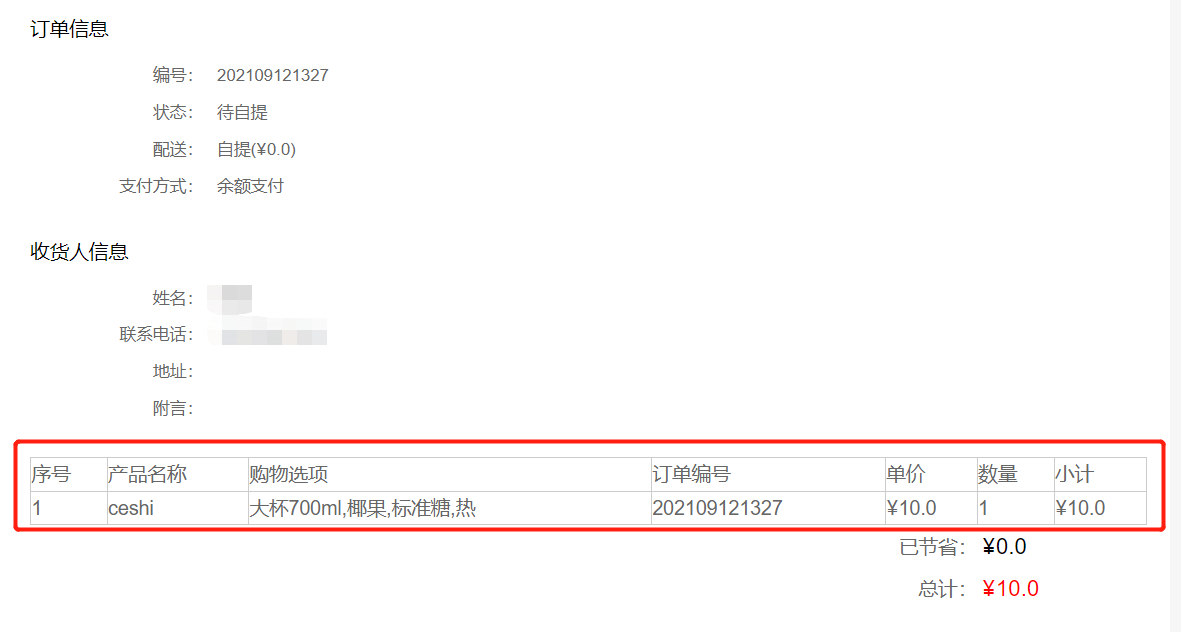

In [1]:
# 需要安装这几个库
from selenium import webdriver
from lxml import etree
import pandas as pd
import time

In [2]:
# 获取浏览器对象
obj = webdriver.Edge()
url = 'https://mail.126.com/'
obj.get(url)
# iframe的第一个元素
iframe = obj.find_elements_by_tag_name('iframe')
obj.switch_to.frame(iframe[0])
time.sleep(1)
# 输入账号和密码，并点击登录
obj.find_element_by_name('email').send_keys('账号')
obj.find_element_by_name('password').send_keys('密码')
obj.find_element_by_id('dologin').click()
# 从iframe中跳出，进入到html网页中
obj.switch_to.default_content()
# 初始化列表来接收所有的数据
product, shop_option, order, price, num, money = [], [], [], [], [], []

In [3]:
# 外层在定义一个循环来获取数据，直到该网页下无数据为止
while(True):
    # 刷新页面
    obj.refresh()
    time.sleep(1)
    # 获取该页面下有多少条订单数据
    n_html = etree.HTML(obj.page_source)
    ss = n_html.xpath('//div[@class="Dg0"]/div[3]//text()')
    n = 0
    for s in ss:
        if '支付订单' in s:
            n += 1
    # 当该页面下订单不为0时执行以下操作，否则跳出循环
    if n != 0:
        # 定义一个循环，针对数据的条数进行抓取
        for k in range(2, n + 2):
            time.sleep(1)
            # 模拟点击第k笔订单
            button = obj.find_element_by_xpath(f'//div[@class="Dg0"]/div[3]/div[{k}]')
            obj.execute_script("$(arguments[0]).click()", button)
            # 直接在这里使用遍历方式来提取文本，若提取到，这直接退出循环（网易反爬——iframe毫无无规律）
            iframe = obj.find_elements_by_tag_name('iframe')
            for j in range(len(iframe)):
                time.sleep(1)
                obj.switch_to.frame(iframe[j])
                # 转换为网页源码
                html = etree.HTML(obj.page_source)
                # 获取对应文本数据
                text = html.xpath('//*[@id="content"]/div[1]/div[2]/div[2]/div[3]/table/tbody//text()')
                # 需要重新从iframe中跳出到html
                obj.switch_to.default_content()
                # 直到获取到对应的表格数据
                if len(text) != 0:
                    break
            # 网页后退
            obj.back()
            # 处理text数据，追加到列表中
            for i in range(1, int(len(text) / 7)):
                product.append(text[1 + i * 7])
                shop_option.append(text[2 + i * 7])
                order.append(str(text[3 + i * 7])
                price.append(text[4 + i * 7])
                num.append(text[5 + i * 7])
                money.append(text[6 + i * 7])
        time.sleep(1)
        # 模拟点击全选
        obj.find_element_by_xpath('//span[@class="nui-chk-symbol"]').click()
        # 之后对选中的邮件进行删除
        obj.find_element_by_xpath('//span[starts-with(text(),"删 除")]').click()
    else:
        break

In [ ]:
# 保存数据到csv中，excel可以直接使用df.to_excel()
df = pd.DataFrame()
df['序号'] = range(len(product))
df['产品名称'] = product
df['购物选项'] = shop_option
df['订单编号'] = order
df['单价'] = price
df['数量'] = num
df['小计'] = money
df.to_csv('./data.csv', encoding = 'gb18030', index = None)

> 参考了一篇[CSDN博文链接](https://blog.csdn.net/baidu_36697353/article/details/93868295?ops_request_misc=&request_id=&biz_id=102&utm_term=%E7%88%AC%E8%99%AB%20%E9%82%AE%E4%BB%B6&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-4-93868295.first_rank_v2_pc_rank_v29&spm=1018.2226.3001.4187)，以下为其源代码部分，但与我上面的实现机制都不相同

In [ ]:
class seleniumMail:
    def __init__(self):
        pass



    '''以下代码实现数据提取'''

    def parse_item(maillist):
        for m in maillist:
            long_text = str(m.attrs['aria-label'])
            yield {
                'e_title': long_text.split('发件人 ：')[0].strip(),
                'e_sender': long_text.split('发件人 ：')[1].split('时间：')[0].strip(),
                'e_send_time': long_text.split('发件人 ：')[1].split('时间：')[1].strip(),
            }

    def login(self):

        driver = webdriver.Chrome()
        driver.get('http://mail.163.com')
        time.sleep(3)

        # 登录
        driver.find_element_by_xpath('//*[@id="switchAccountLogin"]').click()
        iframe = driver.find_elements_by_tag_name("iframe")[0]
        driver.switch_to.frame(iframe)
        driver.find_element_by_name("email").clear()
        driver.find_element_by_name("email").send_keys('****')
        driver.find_element_by_name("password").clear()
        driver.find_element_by_name("password").send_keys("*****")
        driver.find_element_by_id("dologin").click()
        time.sleep(2)
        return driver

    def getInfo(self, driver):
        driver.switch_to.default_content() # 跳出iframe 。一定记住 只要之前跳入iframe，之后就必须跳出。进入主html
        driver.find_element_by_xpath('//*[@id="_mail_component_22_22"]').click()  # 点击收件箱
        time.sleep(5)
        html = driver.page_source
        cookies = driver.get_cookies()
        soup = BeautifulSoup(html, "html.parser")
        count = self.process_soup(driver, soup)
        total_page = int(driver.find_element_by_class_name('nui-select-text').text.split('/')[1])
        print("total-page:", str(total_page))

        print(driver.title)  # 获取标题
        print("success")
        time.sleep(300)

    def process_soup(self, driver, soup):
        mailList = soup.find_all(attrs={"sign": "letter"})
        print(mailList)
        for m in mailList:
            id = str(m.attrs['id'])
            long_text = str(m.attrs['aria-label'])
            # 标题
            title_string = str(long_text.split('发件人 ：')[0].strip())+str(long_text.split('发件人 ：')[1].split('时间：')[0].strip())+str(long_text.split('发件人 ：')[1].split('时间：')[1].strip())
            print("title_string:",title_string)
            print("id:", id)
            print("-" * 30,"process_soup","-" * 30)
            self.getOneInfo(driver, id)

    def getOneInfo(self, driver, id):
        driver.find_element_by_xpath('//*[@id="' + id + '"]').click()
        time.sleep(1)
        iframe = driver.find_elements_by_tag_name("iframe")[3]
        driver.switch_to.frame(iframe)
        # parent = driver.find_element_by_xpath('//*[@id="netease_mail_footer_style"]')
        driver.find_element_by_xpath('/html/body')
        html = driver.page_source
        print(html)
        print("------"*100)
        print(self.processOneInfo(html))
        time.sleep(2)
        driver.switch_to.default_content()
        time.sleep(2)
        driver.find_element_by_tag_name('div div span').click()
        time.sleep(2)

    def processOneInfo(self, html):
        p_string = ""
        print("*"*300)
        soup = BeautifulSoup(html, "html.parser")
        mailList = soup.find_all("div")
        for m in mailList:
            print(m.string)
            p_string += str(m.string)+"\n"
        self.writeIntoWord(p_string)
        return "write to word success"
    def writeIntoWord(self,p_string):
        document = Document('E:\\python_file\\web_spider\\demo.docx')
        if p_string != None:
            document.add_paragraph(p_string)
            document.add_paragraph("\n")
        document.save('E:\\python_file\\web_spider\\demo.docx')

In [9]:
# 获取当前网页
# headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36'}
# current_url = obj.current_url
# cookies = obj.get_cookies()
# cookie_dict = {}
# for i in cookies:
#     cookie_dict[i['name']] = i['value']
# response = requests.get(current_url, headers = headers, cookies = cookie_dict).text
# response

'<!DOCTYPE html><html lang="zh-CN"><head><script id="serviceworker">!function(){try{"serviceWorker"in navigator&&(navigator.serviceWorker.register("./sw.js",{scope:"/js6/"}).then(function(e){console.log("serviceWorker registered")}).catch(function(e){console.log("serviceWorker register",e)}),navigator.serviceWorker.addEventListener("message",function(e){"error"===e.data.type&&console.log("serviceWorker error",e.data),"unhandledrejection"===e.data.type&&console.log("serviceWorker unhandledrejection",e.data)}))}catch(e){console.log("serviceWorker init",e)}}();</script><meta charset="utf-8" /><meta http-equiv="X-UA-Compatible" content="IE=edge" /><title>网易邮箱6.0版</title><link rel="shortcut icon" href="//mail.126.com/favicon.ico"><style type="text/css">@font-face {font-family: \'nui\';src: url(\'https://mimg.127.net/p/font/js6/v1/neteasefont-regular.eot\');src: url(\'https://mimg.127.net/p/font/js6/v1/neteasefont-regular.eot#iefix\') format(\'embedded-opentype\'),url(\'https://mimg.127.net/